In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import collections

import warnings
warnings.filterwarnings('ignore')

# Utils
file_path = os.getcwd()
utils_path = os.path.abspath(os.path.join(file_path, '../src/data'))
sys.path.append(utils_path)
import utils_data

In [2]:
# Load agg response
# rsp = pd.read_csv(os.join.path(file_path, '../data/from_combined'))
rsp = pd.read_csv('/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1/combined_single_response_agg', sep='\t')
rsp.insert(loc=2, column='CELL_abs', value=rsp['CELL'].map(lambda s: s.split('.')[1]))
print('rsp.shape', rsp.shape)
display(rsp[:2])

(4484081, 15)


,SOURCE,CELL,CELL_abs,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1
0,CCLE,CCLE.1321N1,1321N1,CCLE.1,fake_exp,0.8330,4.883,5.183,0.5746,0.9864,0.2017,0.7463,0.1017,0.8983,0.0551
1,CCLE,CCLE.1321N1,1321N1,CCLE.10,fake_exp,0.7909,5.217,5.217,2.2840,0.6526,0.0000,0.8993,0.1136,0.8864,0.0728


# Top6

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet('../uniq.top6.reg.parquet', engine='auto', columns=None)
col_idx = df.nunique(dropna=True).values==1  # col indexes to drop
df = df.iloc[:, ~col_idx]

print(df.shape)

(283152, 3765)


In [3]:
def split_cell_drug(dff):
    """ Split drug and cell features. """
    dff = dff.copy()
    dd_cols = [c for c in df.columns if 'DD_' in c]
    ge_cols = [c for c in df.columns if 'GE_' in c]
    dd = dff[dd_cols]
    ge = dff[ge_cols]
    print('\ndd.shape', dd.shape)
    print('ge.shape', ge.shape)
    return dd, ge


def add_lbl_dup(dff, label_name='lb', prffx='_'):
    """ Add col indicating with unique row (label). """
    idx_org = dff.index.values
    
    # Sort rows (duplicated rows will be concateneted)
    dff = dff.sort_values(by=dff.columns.tolist())
    # Add boolean col indicating the start of new unique row
    dff = pd.concat([dff.duplicated(keep='first'), dff], axis=1).rename(columns={0: 'd'})

    # Add col indicating a unique row
    c = -1
    v = np.ones((len(dff),))
    for i, x in enumerate(dff['d']):
        # if i % 50000 == 0: print(i)
        if x is False:
            c += 1
            v[i] = int(c)
        else:
            v[i] = c

    dff.insert(loc=1, column=label_name, value=v) 
    dff = dff.reindex(idx_org)
    dff = dff.drop(columns=['d'])
    
    dff[label_name] = dff[label_name].map(lambda x: prffx + str(int(x)))
    return dff

In [4]:
dd, ge = split_cell_drug(dff=df)
dlb = add_lbl_dup(dd, label_name='dlb', prffx='d')['dlb']
clb = add_lbl_dup(ge, label_name='clb', prffx='c')['clb']


dd.shape (283152, 2822)
ge.shape (283152, 942)


In [6]:
dd[:2]

,DD_MW,DD_AMW,DD_Sv,DD_Se,DD_Sp,DD_Si,DD_Mv,DD_Me,DD_Mp,DD_Mi,...,DD_Psychotic-80,DD_Psychotic-50,DD_Hypertens-80,DD_Hypertens-50,DD_Hypnotic-80,DD_Hypnotic-50,DD_Neoplastic-80,DD_Neoplastic-50,DD_Infective-80,DD_Infective-50
0,974.73,8.123,76.158,121.421,80.927,135.681,0.635,1.012,0.674,1.131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,974.73,8.123,76.158,121.421,80.927,135.681,0.635,1.012,0.674,1.131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
ge[:2]

,GE_AARS,GE_ABCB6,GE_ABCC5,GE_ABCF1,GE_ABCF3,GE_ABHD4,GE_ABHD6,GE_ABL1,GE_ACAA1,GE_ACAT2,...,GE_ZMIZ1,GE_ZMYM2,GE_ZNF131,GE_ZNF274,GE_ZNF318,GE_ZNF395,GE_ZNF451,GE_ZNF586,GE_ZNF589,GE_ZW10
0,-2.7680,-0.929,-0.7397,-2.2230,-2.08,-0.624,-0.010086,0.3992,0.6140,-0.65500,...,0.1420,-0.7695,-0.4844,-0.6543,-1.4460,-0.8420,-0.3555,-0.4753,-1.339,-0.4937
1,0.8354,0.553,-0.3386,0.6025,-0.73,-0.685,1.184000,0.4116,-0.0731,-0.01535,...,0.5327,0.6830,0.0725,0.2411,-0.2615,-0.1866,-0.2996,1.3545,1.356,1.5620


In [8]:
print(len(dlb.unique()))
print(len(clb.unique()))

1748
748


## How come there combinations that were tested more than 100 times??

In [15]:
# Unique combinations
xdata = df.iloc[:,1:].copy()
df_ = add_lbl_dup(xdata, label_name='cmb', prffx='s')

In [21]:
# How come there combinations that were tested more than 100 times??
df_['cmb'].value_counts()[:5]

s2551    128
s2553    127
s2552    127
s2542    126
s2558    125
Name: cmb, dtype: int64

In [22]:
print(x_tmp.shape)
x_tmp = xdata.drop_duplicates()
print(x_tmp.shape)

In [ ]:
mm = dlb + '_' + clb
mm.value_counts()[:10]

In [25]:
bool(eval('0'))

False

In [28]:
bool(eval('yes'))

NameError: name 'yes' is not defined

In [45]:
import os
from pathlib import Path
import pandas as pd
path = Path(os.getcwd())

import matplotlib.pyplot as plt

In [33]:
path = path/'../models/candle_accl_trn'
wrmdir = path/'wrm/split_by_none'
refdir = path/'ref/split_by_none'

In [34]:
h_wrm = pd.read_csv(wrmdir/'keras_history.csv')
h_ref = pd.read_csv(refdir/'keras_history.csv')

In [41]:
h_wrm.index.values + 1

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [42]:
h_wrm['epoch'] = h_wrm.index.values + 1
h_ref['epoch'] = h_wrm.index.values + 1

In [43]:
OUTDIR = path

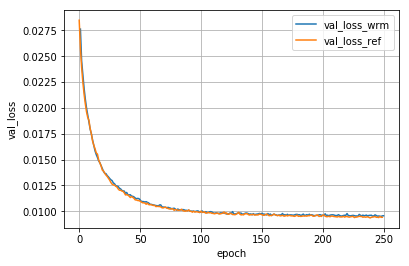

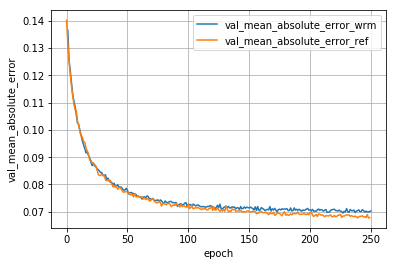

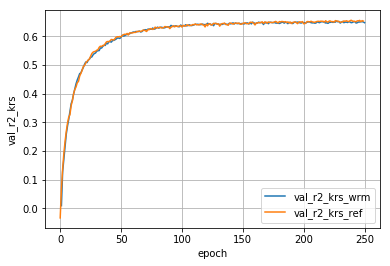

In [44]:
val_cols_names = [c for c in h_ref.columns if 'val_' in c]
for c in val_cols_names:
    fig, ax = plt.subplots()
    
    ax.plot(h_wrm['epoch'], h_wrm[c], label=c+'_wrm')
    ax.plot(h_ref[c], label=c+'_ref')
    ax.set_xlabel('epoch')
    ax.set_ylabel(c)
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig(OUTDIR/f'../wrm_vs_ref_{c}.png', bbox_inches='tight')

In [80]:
path = path/'../models/candle_accl_trn'
wrmdir = path/'wrm/split_by_none'
refdir = path/'ref/split_by_none'

In [69]:
h_ref = pd.read_csv(refdir/'keras_history.csv')
# h_ref = pd.read_csv(refdir/'model.ref.log')

In [49]:
path

PosixPath('/vol/ml/apartin/projects/cell-line-drug-sensitivity/notebooks/../models/candle_accl_trn')

In [79]:
val_cols_names = [c for c in h_ref.columns if 'val_' in c]

In [77]:
ref_ep = 300
weps = 40
cdir = path/f'cnt_val_loss_at_{ref_ep}'/'split_by_none'/f'weps_{weps}'
df = pd.read_csv(cdir/'model.cnt.log')
df['epoch'] += 1

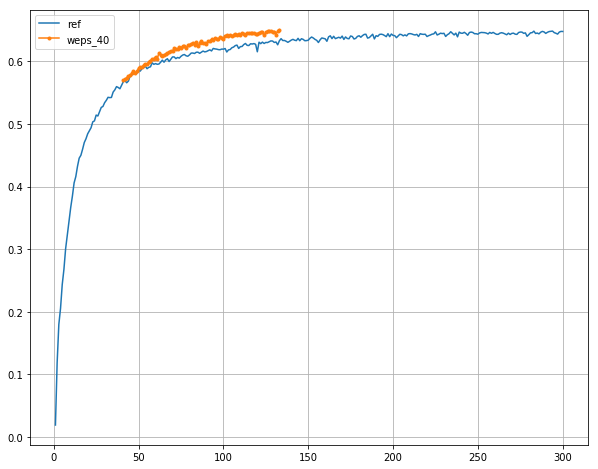

In [78]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(h_ref['epoch'], h_ref['val_r2_krs'], label='ref')
ax.plot(df['epoch']+weps, df['val_r2_krs'], '.-', label=f'weps_{weps}')
plt.legend()
plt.grid(True)

In [75]:
val_cols_names = [c for c in h_ref.columns if 'val_' in c]

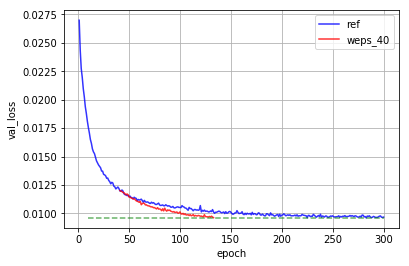

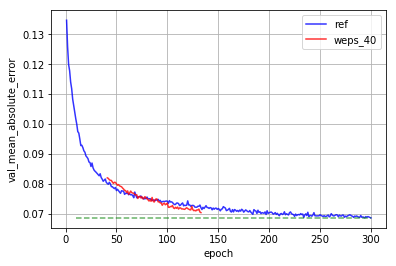

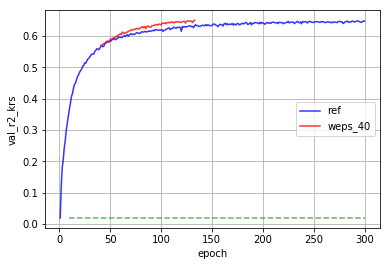

In [140]:
for c in val_cols_names:
    fig, ax = plt.subplots()
    # ax.plot(h_wrm['epoch'], h_wrm[c], label=c+'_wrm')
    # ax.plot(h_ref[c], label=c+'_ref')
    
    x = np.array(range(skp_ep, h_ref['epoch'].values[-1] + 1))
    y = np.ones((len(x))) * min(h_ref[c])
    
    alpha=0.8
    ax.plot(h_ref['epoch'], h_ref[c], 'b-', alpha=alpha, label='ref')
    ax.plot(df['epoch']+weps, df[c], 'r-', alpha=alpha, label=f'weps_{weps}')
    ax.plot(x, y, 'g--', alpha=0.6)
    
    ax.set_xlabel('epoch')
    ax.set_ylabel(c)
    plt.legend(loc='best')
    plt.grid(True)
    # plt.savefig(outdir/f'wrm_vs_ref_{c}.png', bbox_inches='tight')

In [82]:
import numpy as np

In [108]:
x = np.asarray(range(0, h_ref['epoch'].values[-1] + 1))

In [114]:
skp_ep = 10
x = np.array(range(skp_ep, h_ref['epoch'].values[-1] + 1))
y = np.ones((len(x))) * min(h_ref[c])

In [118]:
len(y)

291

In [116]:
y

array([0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924879,
       0.01924879, 0.01924879, 0.01924879, 0.01924879, 0.01924

In [97]:
np.linspace(0, h_ref['epoch'].values[-1])

array([  0.        ,   6.12244898,  12.24489796,  18.36734694,
        24.48979592,  30.6122449 ,  36.73469388,  42.85714286,
        48.97959184,  55.10204082,  61.2244898 ,  67.34693878,
        73.46938776,  79.59183673,  85.71428571,  91.83673469,
        97.95918367, 104.08163265, 110.20408163, 116.32653061,
       122.44897959, 128.57142857, 134.69387755, 140.81632653,
       146.93877551, 153.06122449, 159.18367347, 165.30612245,
       171.42857143, 177.55102041, 183.67346939, 189.79591837,
       195.91836735, 202.04081633, 208.16326531, 214.28571429,
       220.40816327, 226.53061224, 232.65306122, 238.7755102 ,
       244.89795918, 251.02040816, 257.14285714, 263.26530612,
       269.3877551 , 275.51020408, 281.63265306, 287.75510204,
       293.87755102, 300.        ])

In [96]:
h_ref['epoch'].values[-1]

300

In [95]:
h_ref['epoch']

0        1
1        2
2        3
3        4
4        5
5        6
6        7
7        8
8        9
9       10
10      11
11      12
12      13
13      14
14      15
15      16
16      17
17      18
18      19
19      20
20      21
21      22
22      23
23      24
24      25
25      26
26      27
27      28
28      29
29      30
      ... 
270    271
271    272
272    273
273    274
274    275
275    276
276    277
277    278
278    279
279    280
280    281
281    282
282    283
283    284
284    285
285    286
286    287
287    288
288    289
289    290
290    291
291    292
292    293
293    294
294    295
295    296
296    297
297    298
298    299
299    300
Name: epoch, Length: 300, dtype: int64